In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import re
import torch 

from collections import defaultdict
from utils import *
from eeg_feature_extraction.eeg_utils import *
%matplotlib inline

In [24]:
def normalize_freqs(freqs): 
    normalized_freq = defaultdict(float)
    max_freq = np.max(list(freqs.values()))
    for word, freq in freqs.items():
        normalized_freq[word] = freq / max_freq
    return normalized_freq

In [12]:
bnc_freqs = get_bncfreq()

In [26]:
normalized_bnc_freqs = normalize_freqs(bnc_freqs)

In [13]:
# load embeddings
embeddings_45d = load_embeddings('binary', k = 15)
embeddings_90d = load_embeddings('binary', k = 30)

In [16]:
k_small = 15
k_large = 30

In [47]:
embeddings_45d_RF_NR, embeddings_45d_RF_TSR = embeddings_45d[2], embeddings_45d[3]
embeddings_90d_RF_NR, embeddings_90d_RF_TSR = embeddings_90d[2], embeddings_90d[3]

In [34]:
embeddings_45d_RF_NR_theta, embeddings_45d_RF_TSR_theta = embeddings_45d[2][:, :k_small], embeddings_45d[3][:, :k_small]
embeddings_90d_RF_NR_theta, embeddings_90d_RF_TSR_theta = embeddings_90d[2][:, :k_large], embeddings_90d[3][:, :k_large]

In [35]:
embeddings_45d_RF_NR_alpha, embeddings_45d_RF_TSR_alpha = embeddings_45d[2][:, k_small:k_small*2], embeddings_45d[3][:, k_small:k_small*2]
embeddings_90d_RF_NR_alpha, embeddings_90d_RF_TSR_alpha = embeddings_90d[2][:, k_large:k_large*2], embeddings_90d[3][:, k_large:k_large*2]

In [36]:
embeddings_45d_RF_NR_beta, embeddings_45d_RF_TSR_beta = embeddings_45d[2][:, k_small*2:k_small*3], embeddings_45d[3][:, k_small*2:k_small*3]
embeddings_90d_RF_NR_beta, embeddings_90d_RF_TSR_beta = embeddings_90d[2][:, k_large*2:k_large*3], embeddings_90d[3][:, k_large*2:k_large*3]

In [4]:
files_nr = get_matfiles('task2')
files_tsr = get_matfiles('task3')

data_nr = io.loadmat(files_nr[0], squeeze_me=True, struct_as_record=False)['sentenceData']
data_tsr = io.loadmat(files_tsr[0], squeeze_me=True, struct_as_record=False)['sentenceData']

sentences_nr = [sent.content.split() for i, sent in enumerate(data_nr) if i not in get_held_out_sents('task2')]
sentences_tsr = [sent.content.split() for i, sent in enumerate(data_tsr) if i not in get_held_out_sents('task3')]

In [50]:
def compute_word_weights(sent_embeddings:np.ndarray, computation:str, attention_weights=False, e=2):
    func = np.mean if computation == 'avg' else np.max
    word_weights = np.array(list(map(func, sent_embeddings)))
    # add small value to every weight to avoid multiplications or divisions by zero
    word_weights += 1e-5
    # NOTE: use softmax only, if you want to compute attention weights, and not attention scores (maybe for visualisation?)
    if attention_weights:
        def softmax(e): return np.exp(e) / np.sum(np.exp(e))
        word_weights = softmax(word_weights)
        assert word_weights.sum() == float(1)
    else:
        # normalize scores by maximum sentence activity to get values within range [0, 1]
        word_weights /= np.max(word_weights)
        # divide word weights by some constant e to get smaller valuse and make computations numerically more stable
        word_weights /= e
    return word_weights

In [51]:
def get_attention_scores(embeddings:np.ndarray, sentences:list, computation:str):
    n_sents, n_words = len(sentences), embeddings.shape[0]
    df = pd.DataFrame(index = range(0, n_words+n_sents), columns = ['word', 'eeg_weight'])
    cum_sent_len = 0
    cum_df_idx = 0
    for i, sent in enumerate(sentences):
        sent_length = len(sent)
        sent_embeddings = embeddings[cum_sent_len:cum_sent_len+sent_length]
        word_weights = compute_word_weights(sent_embeddings, computation)
        df.iloc[cum_df_idx:cum_df_idx+sent_length, 0] = sent
        df.iloc[cum_df_idx:cum_df_idx+sent_length, 1] = word_weights
        df.iloc[cum_df_idx+sent_length, :] = ' '
        cum_df_idx += sent_length + 1
        cum_sent_len += sent_length
    return df

In [52]:
weights_45d_RF_NR_Max = get_attention_scores(embeddings_45d_RF_NR, sentences_nr, 'max')
weights_45d_RF_TSR_Max = get_attention_scores(embeddings_45d_RF_TSR, sentences_tsr, 'max')

weights_90d_RF_NR_Max = get_attention_scores(embeddings_90d_RF_NR, sentences_nr, 'max')
weights_90d_RF_TSR_Max = get_attention_scores(embeddings_90d_RF_TSR, sentences_tsr, 'max')

In [53]:
weights_15d_RF_NR_Max_alpha = get_attention_scores(embeddings_45d_RF_NR_alpha, sentences_nr,'max')
weights_15d_RF_TSR_Max_alpha = get_attention_scores(embeddings_45d_RF_TSR_alpha, sentences_tsr, 'max')

weights_30d_RF_NR_Max_alpha = get_attention_scores(embeddings_90d_RF_NR_alpha, sentences_nr, 'max') 
weights_30d_RF_TSR_Max_alpha = get_attention_scores(embeddings_90d_RF_TSR_alpha, sentences_tsr, 'max')

In [54]:
weights_15d_RF_NR_Max_theta = get_attention_scores(embeddings_45d_RF_NR_theta, sentences_nr,'max')
weights_15d_RF_TSR_Max_theta = get_attention_scores(embeddings_45d_RF_TSR_theta, sentences_tsr, 'max')

weights_30d_RF_NR_Max_theta = get_attention_scores(embeddings_90d_RF_NR_theta, sentences_nr, 'max') 
weights_30d_RF_TSR_Max_theta = get_attention_scores(embeddings_90d_RF_TSR_theta, sentences_tsr, 'max')

In [55]:
weights_15d_RF_NR_Max_beta = get_attention_scores(embeddings_45d_RF_NR_beta, sentences_nr,'max')
weights_15d_RF_TSR_Max_beta = get_attention_scores(embeddings_45d_RF_TSR_beta, sentences_tsr, 'max')

weights_30d_RF_NR_Max_beta = get_attention_scores(embeddings_90d_RF_NR_beta, sentences_nr, 'max') 
weights_30d_RF_TSR_Max_beta = get_attention_scores(embeddings_90d_RF_TSR_beta, sentences_tsr, 'max')

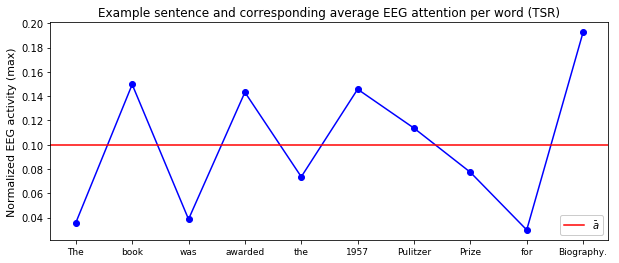

In [25]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Max[74:84])), weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_TSR_Max[74:84][:15])), weights_90d_RF_TSR_Max[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG attention per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

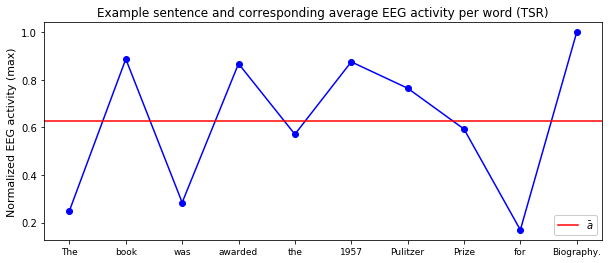

In [41]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Max[74:84])), weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float'), 'ob-')
#plt.plot(range(len(weights_90d_RF_TSR_Max[74:84])), [normalized_bnc_freqs[re.sub('[^\w\s]','',word).lower()] for word in weights_90d_RF_TSR_Max[74:84].word.values], 'og-', label = 'BNC frequency')
plt.axhline(y=weights_90d_RF_TSR_Max[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_TSR_Max[74:84][:15])), weights_90d_RF_TSR_Max[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

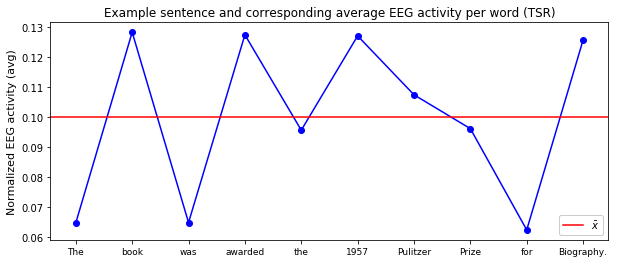

In [26]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Mean[74:84])), weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar x$')
plt.xticks(range(len(weights_90d_RF_TSR_Mean[74:84][:15])), weights_90d_RF_TSR_Mean[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

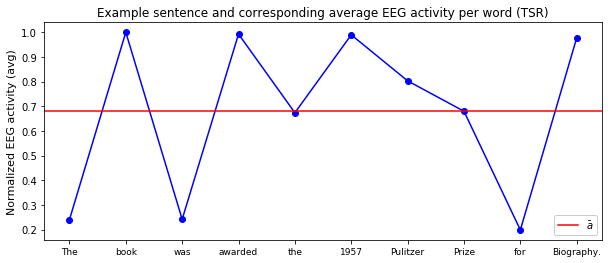

In [12]:
plt.figure(figsize=(10,4))
plt.plot(range(len(weights_90d_RF_TSR_Mean[74:84])), weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_TSR_Mean[74:84].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_TSR_Mean[74:84][:15])), weights_90d_RF_TSR_Mean[74:84].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (TSR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

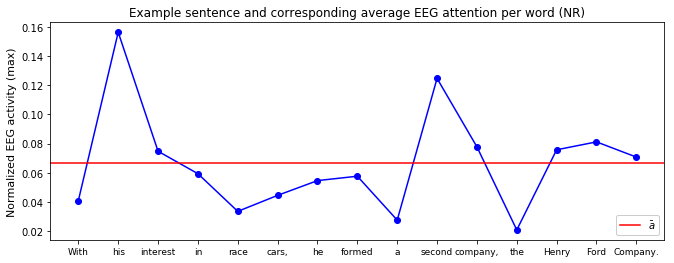

In [30]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG attention per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

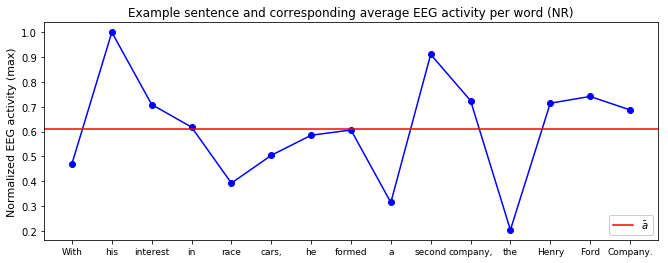

In [11]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Max[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Max[:15])), weights_90d_RF_NR_Max[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (max)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

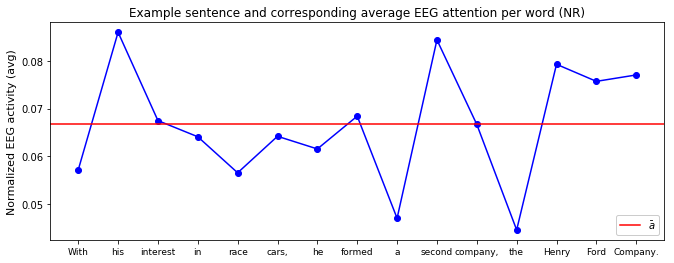

In [31]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG attention per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

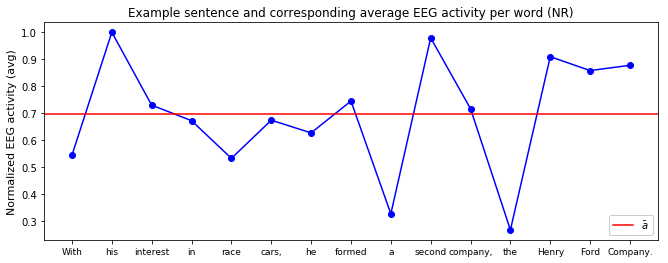

In [12]:
plt.figure(figsize=(11,4))
plt.plot(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float'), 'ob-')
plt.axhline(y=weights_90d_RF_NR_Mean[:15].eeg_weight.values.astype('float').mean(), color='r', linestyle='-', label=r'$\bar a$')
plt.xticks(range(len(weights_90d_RF_NR_Mean[:15])), weights_90d_RF_NR_Mean[:15].word.values, fontsize = 9)
plt.ylabel('Normalized EEG activity (avg)', fontsize=11)
plt.title('Example sentence and corresponding average EEG activity per word (NR)')
plt.legend(fancybox=True, framealpha=1, loc='lower right', prop={'size':10})
plt.show()

In [13]:
os.mkdir('attention_scores')

In [56]:
weights_45d_RF_NR_Max.to_csv('./attention_scores/weights_45d_RF_NR_Max.csv', sep='\t', index=False, header=False)
weights_45d_RF_TSR_Max.to_csv('./attention_scores/weights_45d_RF_TSR_Max.csv', sep='\t', index=False, header=False)
weights_90d_RF_NR_Max.to_csv('./attention_scores/weights_90d_RF_NR_Max.csv', sep='\t', index=False, header=False)
weights_90d_RF_TSR_Max.to_csv('./attention_scores/weights_90d_RF_TSR_Max.csv', sep='\t', index=False, header=False)

In [57]:
weights_15d_RF_NR_Max_alpha.to_csv('./attention_scores/weights_15d_RF_NR_Max_alpha.csv', sep='\t', index=False, header=False)
weights_15d_RF_TSR_Max_alpha.to_csv('./attention_scores/weights_15d_RF_TSR_Max_alpha.csv', sep='\t', index=False, header=False)
weights_30d_RF_NR_Max_alpha.to_csv('./attention_scores/weights_30d_RF_NR_Max_alpha.csv', sep='\t', index=False, header=False)
weights_30d_RF_TSR_Max_alpha.to_csv('./attention_scores/weights_30d_RF_TSR_Max_alpha.csv', sep='\t', index=False, header=False)

In [58]:
weights_15d_RF_NR_Max_theta.to_csv('./attention_scores/weights_15d_RF_NR_Max_theta.csv', sep='\t', index=False, header=False)
weights_15d_RF_TSR_Max_theta.to_csv('./attention_scores/weights_15d_RF_TSR_Max_theta.csv', sep='\t', index=False, header=False)
weights_30d_RF_NR_Max_theta.to_csv('./attention_scores/weights_30d_RF_NR_Max_theta.csv', sep='\t', index=False, header=False)
weights_30d_RF_TSR_Max_theta.to_csv('./attention_scores/weights_30d_RF_TSR_Max_theta.csv', sep='\t', index=False, header=False)

In [59]:
weights_15d_RF_NR_Max_beta.to_csv('./attention_scores/weights_15d_RF_NR_Max_beta.csv', sep='\t', index=False, header=False)
weights_15d_RF_TSR_Max_beta.to_csv('./attention_scores/weights_15d_RF_TSR_Max_beta.csv', sep='\t', index=False, header=False)
weights_30d_RF_NR_Max_beta.to_csv('./attention_scores/weights_30d_RF_NR_Max_beta.csv', sep='\t', index=False, header=False)
weights_30d_RF_TSR_Max_beta.to_csv('./attention_scores/weights_30d_RF_TSR_Max_beta.csv', sep='\t', index=False, header=False)

In [ ]:
#os.mkdir('attention_weights')

In [29]:
# NOTE: Execute this cell only, if you are using softmax EEG attention weights (!)
#weights_45d_RF_NR_Max.to_csv('./attention_weights/weights_45d_RF_NR_Max_softmax.csv', sep='\t', index=False, header=False)
#weights_45d_RF_TSR_Max.to_csv('./attention_weights/weights_45d_RF_TSR_Max_softmax.csv', sep='\t', index=False, header=False)
#weights_90d_RF_NR_Max.to_csv('./attention_weights/weights_90d_RF_NR_Max_softmax.csv', sep='\t', index=False, header=False)
#weights_90d_RF_TSR_Max.to_csv('./attention_weights/weights_90d_RF_TSR_Max_softmax.csv', sep='\t', index=False, header=False)

#weights_45d_RF_NR_Mean.to_csv('./attention_weights/weights_45d_RF_NR_Mean_softmax.csv', sep='\t', index=False, header=False)
#weights_45d_RF_TSR_Mean.to_csv('./attention_weights/weights_45d_RF_TSR_Mean_softmax.csv', sep='\t', index=False, header=False)
#weights_90d_RF_NR_Mean.to_csv('./attention_weights/weights_90d_RF_NR_Mean_softmax.csv', sep='\t', index=False, header=False)
#weights_90d_RF_TSR_Mean.to_csv('./attention_weights/weights_90d_RF_TSR_Mean_softmax.csv', sep='\t', index=False, header=False)